# Test set evaluation
We take our top model now and use it to generate final results

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
encoder_list = ["minilm", "deberta"] #["minilm"]
test_metrics = ["auprc"]

encoder_top_models = {'minilm': ('k25_r1_alpha0.050_tau1.00_lamnan.model', 0.7)} 
# old: k10_r2_alpha0.010_tau0.00_lamnan.model
baseline_top_models = \
        {'minilm': [('mlp', ">"), ("svd", "<")], \
        'deberta': [('deberta-prob', '>'), ('deberta-attn', '>'), ('deberta-entail', '>')]}
    # {'minilm': [('mlp', ">"), ("svd", "<")]}

In [31]:
from evaluation import test_eval, extract_params, get_test_metrics
import utils
import pandas as pd

In [32]:
# encoder="minilm"
# base_df = []
# for model_thresh_pair in baseline_top_models["minilm"]:
#     best_model, best_thresh = model_thresh_pair
#     results_dict = utils.deserialize("/dfs/scratch1/gmachi/k2/K2/src/outputs/baselines/" + best_model +"-full.obj")
#     df = get_test_metrics(results_dict, encoder, best_model, best_thresh, test_metrics)
#     # add a "method" column to the df (K2, Attn, Prob)
#     df["method"] = best_model.split("_")[0]
#     base_df.append(df)
# base_df = pd.concat(base_df)

base_df = []
for encoder in ["minilm", "deberta"]:
    for model_thresh_pair in baseline_top_models[encoder]:
        best_model, best_thresh = model_thresh_pair
        results_dict = utils.deserialize("/dfs/scratch1/gmachi/k2/K2/src/outputs/baselines/" + best_model +"-full.obj")
        df = get_test_metrics(results_dict, encoder, best_model, best_thresh, test_metrics)
        # add a "method" column to the df (K2, Attn, Prob)
        df["method"] = best_model.split("_")[0]
        base_df.append(df)
base_df = pd.concat(base_df)


In [33]:
# base_df['encoder'] = df['encoder'].str.lower()


In [34]:
base_df

,encoder,model,threshold,datum_id,regime,metric,value,method
0,minilm,mlp,"(>, 0.005527460360181952)",doc_448_graph.obj,all,auprc,NaN,mlp
1,minilm,mlp,"(>, 0.0014154207124087426)",doc_326_graph.obj,all,auprc,NaN,mlp
2,minilm,mlp,"(>, 0.47144088990613775)",doc_283_graph.obj,all,auprc,NaN,mlp
3,minilm,mlp,"(>, 0.0016427044192025768)",doc_155_graph.obj,all,auprc,NaN,mlp
4,minilm,mlp,"(>, 0.4096924348431235)",doc_59_graph.obj,all,auprc,0.513889,mlp
...,...,...,...,...,...,...,...,...
707,deberta,deberta-entail,"(>, 0.1997234837714738)",doc_26_graph.obj,all,auprc,NaN,deberta-entail
708,deberta,deberta-entail,"(>, 0.04813457939308137)",doc_187_graph.obj,all,auprc,NaN,deberta-entail
709,deberta,deberta-entail,"(>, 0.0019418112351559103)",doc_712_graph.obj,all,auprc,NaN,deberta-entail
710,deberta,deberta-entail,"(>, 0.13185059900241602)",doc_78_graph.obj,all,auprc,NaN,deberta-entail


added speed test

In [36]:
speed_test=True

In [50]:
from time import process_time 
from time import perf_counter

In [51]:
test_df = []
all_cpus, all_walls = [], []
for encoder, (model_str, threshold) in encoder_top_models.items():
    encoder_alias = encoder.lower()
    cache_dir = "/dfs/scratch1/gmachi/k2/K2/src/outputs/wikisection/" + encoder_alias + "_gridsearch/"
    results_cache_dir = cache_dir + encoder_alias + "-eval_results"
    model_cache_dir = cache_dir + encoder_alias + "-fitted_k2_models"
    processor_cache_dir = cache_dir + encoder_alias + "-fitted_k2_processors"
    linearized_cache_dir = cache_dir + encoder_alias + "-linearized_data"

    G_dir = "/dfs/scratch1/gmachi/datasets/wikisection_processed/test_Gs"  #+ encoder_alias
    gt_dir = "/dfs/scratch1/gmachi/datasets/wikisection_processed/test_gts" #+ encoder_alias
    label_dict = utils.deserialize("/dfs/scratch1/gmachi/datasets/wikisection_processed/test-doc-labs.obj")

    if speed_test == False:
        df = test_eval(model_str, threshold, test_metrics, model_cache_dir, processor_cache_dir, G_dir, gt_dir=gt_dir, label_dict=label_dict, modality="text", arm="test", speed_test=speed_test)
    else:
        t1_cpu = process_time()  
        t1_wall = perf_counter() 
        df, cpu, wall = test_eval(model_str, threshold, test_metrics, model_cache_dir, processor_cache_dir, G_dir, gt_dir=gt_dir, label_dict=label_dict, modality="text", arm="test", speed_test=speed_test)
        t2_cpu = process_time()  
        t2_wall  = perf_counter() 
        print(float(t2_cpu - t1_cpu)) 
        print(float(t2_wall - t1_wall))
        all_cpus.append(cpu)
        all_walls.append(wall)
        
    df['method'] = 'K2'
    test_df.append(df)
test_df = pd.concat(test_df)

dt cpu -> datum: 0.018409618999982058
dt wall -> datum: 0.018266521394252777
dt cpu -> datum: 0.06711194900000805
dt wall -> datum: 0.06711040064692497
dt cpu -> datum: 0.026990012000027264
dt wall -> datum: 0.026989515870809555
dt cpu -> datum: 0.20064597699999354
dt wall -> datum: 0.19905738160014153
dt cpu -> datum: 0.03009061699998483
dt wall -> datum: 0.030089814215898514
dt cpu -> datum: 0.2111108530000081
dt wall -> datum: 0.20950192585587502
dt cpu -> datum: 0.02735945099999526
dt wall -> datum: 0.02736765518784523
dt cpu -> datum: 0.1808242109999867
dt wall -> datum: 0.1799830198287964
dt cpu -> datum: 0.004170702000010351
dt wall -> datum: 0.004170700907707214
dt cpu -> datum: 0.17366870299997572
dt wall -> datum: 0.17366430163383484
dt cpu -> datum: 0.061520367000014176
dt wall -> datum: 0.06096046045422554
dt cpu -> datum: 0.05808995999998956
dt wall -> datum: 0.05808912217617035
dt cpu -> datum: 0.16776155200000176
dt wall -> datum: 0.16636304929852486
dt cpu -> datum: 0.1

In [52]:
combined_df = pd.concat([test_df, base_df])

mean_df = combined_df.groupby(['encoder', 'method','regime', 'metric'])['value'].mean().reset_index()
sem_df = combined_df.groupby(['encoder', 'method','regime', 'metric'])['value'].sem().reset_index()

mean_pvt = mean_df.pivot(index=['encoder', 'method', 'regime'], columns='metric', values='value')
mean_pvt = mean_pvt[test_metrics]

sem_pvt = sem_df.pivot(index=['encoder', 'method', 'regime'], columns='metric', values='value')
sem_pvt = sem_pvt[test_metrics]

#Save dfs
mean_pvt.to_csv('/dfs/scratch1/gmachi/k2/K2/src/outputs/wikisection/all_test_results_mean-ALL-COMPLETE-NEW.csv')
sem_pvt.to_csv('/dfs/scratch1/gmachi/k2/K2/src/outputs/wikisection/all_test_results_sem-ALL-COMPLETE-NEW.csv')
combined_df.to_csv('/dfs/scratch1/gmachi/k2/K2/src/outputs/wikisection/all_test_results_points-ALL-COMPLETE-NEW.csv') # graph-level results
test_df.to_csv('/dfs/scratch1/gmachi/k2/K2/src/outputs/wikisection/k2_test_results_points-ALL-COMPLETE-NEW.csv')  # k2 only


## speed test results

In [53]:
import numpy as np
encoders = ["tile2vec", "vit", "clip", "plip"]

for i, cpu in enumerate(all_cpus):
    print(encoders[i], np.mean(cpu), np.std(cpu))

for i, wall in enumerate(all_walls):
    print(encoders[i], np.mean(wall), np.std(wall))

tile2vec 0.12774761485376054 0.1368704410254188
tile2vec 0.1272699632642993 0.13644921688126058


# Properties vs performance

In [44]:
from evaluation import compute_test_mrds, compute_test_rps, compute_test_mcs, compute_test_ccs

gts_path = "/dfs/scratch1/gmachi/datasets/wikisection_processed/test_gts"
rps_dict = compute_test_rps(gts_path, modality="text")
mrds_dict = compute_test_mrds(gts_path, modality="text")
ccs_dict = compute_test_ccs(gts_path, modality="text")
mcs_dict = compute_test_mcs(gts_path, modality="text")

/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dfs/scratch1/gmachi/k2/K2/src/evaluation.py:560: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(size_cc) / len(size_cc) # prevalence / num CC


In [45]:
len(rps_dict.keys())

718

In [46]:
inter = set(rps_dict.keys()).intersection(set(test_df["datum_id"]))
len(inter)

712

In [47]:
test_df

,encoder,model,threshold,datum_id,regime,metric,value,method
0,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_700_graph.obj,all,auprc,NaN,K2
1,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_573_graph.obj,all,auprc,NaN,K2
2,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_488_graph.obj,all,auprc,NaN,K2
3,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_243_graph.obj,all,auprc,NaN,K2
4,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_195_graph.obj,all,auprc,NaN,K2
...,...,...,...,...,...,...,...,...
707,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_401_graph.obj,all,auprc,NaN,K2
708,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_251_graph.obj,all,auprc,NaN,K2
709,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_187_graph.obj,all,auprc,NaN,K2
710,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_712_graph.obj,all,auprc,NaN,K2


In [48]:
test_df['rp'] = test_df['datum_id'].map(rps_dict)
test_df['mrd'] = test_df['datum_id'].map(mrds_dict)
test_df['ccs'] = test_df['datum_id'].map(ccs_dict)
test_df['mcs'] = test_df['datum_id'].map(mcs_dict)
test_df['srp'] = test_df['rp'] / test_df['ccs']

In [49]:
test_df

,encoder,model,threshold,datum_id,regime,metric,value,method,rp,mrd,ccs,mcs,srp
0,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_700_graph.obj,all,auprc,NaN,K2,0.0,NaN,0,NaN,NaN
1,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_573_graph.obj,all,auprc,NaN,K2,0.0,NaN,0,NaN,NaN
2,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_488_graph.obj,all,auprc,NaN,K2,0.0,NaN,0,NaN,NaN
3,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_243_graph.obj,all,auprc,NaN,K2,0.0,NaN,0,NaN,NaN
4,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_195_graph.obj,all,auprc,NaN,K2,0.0,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_401_graph.obj,all,auprc,NaN,K2,0.0,NaN,0,NaN,NaN
708,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_251_graph.obj,all,auprc,NaN,K2,0.0,NaN,0,NaN,NaN
709,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_187_graph.obj,all,auprc,NaN,K2,0.0,NaN,0,NaN,NaN
710,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_712_graph.obj,all,auprc,NaN,K2,0.0,NaN,0,NaN,NaN


In [50]:
set(test_df["ccs"])

{0, 1, 2}

In [51]:
test_df.loc[test_df['encoder'].str.contains('minilm'), 'encoder'] = 'MiniLM'

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils

def setup_figure(width=6, height=3):
    sns.set(style='white')
    sns.set_context('paper')
    plt.figure(figsize=(width,height))
    
pal = sns.color_palette('tab20')

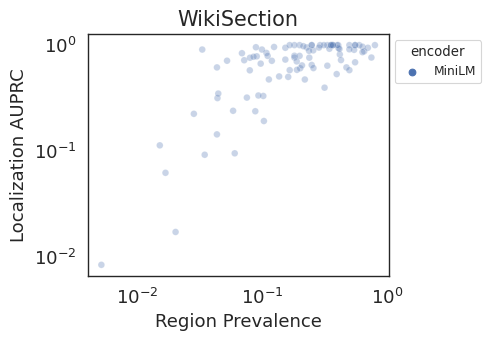

In [53]:
setup_figure(5,3.5)
met="auprc"
g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.3)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
g.set_xscale("log")
g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Region Prevalence', fontsize=13)
g.set_ylabel('Localization AUPRC', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("WikiSection", fontsize=15)

plt.tight_layout()
plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-rp_" + met + ".png", dpi=300, format='png')
plt.show()

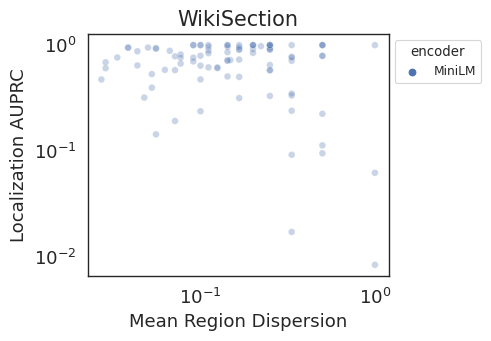

In [54]:
setup_figure(5,3.5)
g = sns.scatterplot(data=test_df, x="mrd", y="value", hue="encoder", alpha=0.3)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
g.set_xscale("log")
g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Mean Region Dispersion', fontsize=13)
g.set_ylabel('Localization AUPRC', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("WikiSection", fontsize=15)

plt.tight_layout()
plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-mrd_" + met + ".png", dpi=300, format='png')
plt.show()

# Trying rolling average

In [80]:
import numpy as np
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'full')

/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


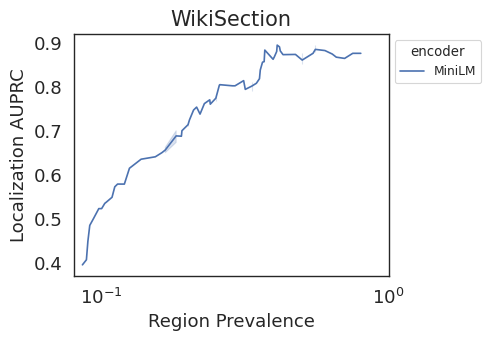

In [89]:
running_means = test_df.sort_values('rp').groupby('encoder').apply(lambda x: movingaverage(x['value'], 20))
mean_data = []
for enc, df in test_df.sort_values('rp').groupby('encoder'):
    mean_data.extend(list(zip(df['rp'], running_means[enc], [enc]*len(df))))
mean_data = pd.DataFrame(mean_data, columns=['rp', 'value', 'encoder'])

met = test_metrics[0]
setup_figure(5,3.5)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", size="ccs", sizes=(10, 100), alpha=0.3)
g = sns.lineplot(data=mean_data.reset_index(), x='rp', y='value', hue='encoder', hue_order=['MiniLM'])
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
g.set_xscale("log")
g.set_xlim(8e-2, 1e0) # added for clarity
 
# g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Region Prevalence', fontsize=13)
g.set_ylabel('Localization AUPRC', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("WikiSection", fontsize=15)
plt.tight_layout()
plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-rp_" + met + "_LINE.png", dpi=300, format='png')
plt.show()

/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


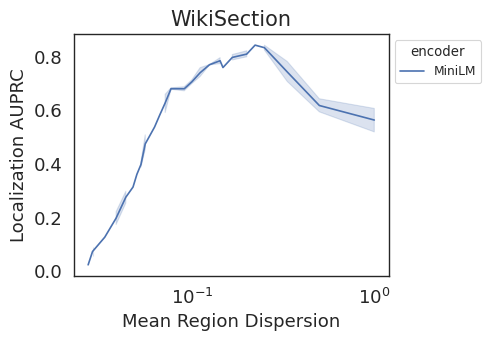

In [86]:
running_means = test_df.sort_values('mrd').groupby('encoder').apply(lambda x: movingaverage(x['value'], 20))
mean_data = []
for enc, df in test_df.sort_values('mrd').groupby('encoder'):
    mean_data.extend(list(zip(df['mrd'], running_means[enc], [enc]*len(df))))
mean_data = pd.DataFrame(mean_data, columns=['mrd', 'value', 'encoder'])

met = test_metrics[0]
setup_figure(5,3.5)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", size="ccs", sizes=(10, 100), alpha=0.3)
g = sns.lineplot(data=mean_data.reset_index(), x='mrd', y='value', hue='encoder', hue_order=['MiniLM'])
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
g.set_xscale("log")
# g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Mean Region Dispersion', fontsize=13)
g.set_ylabel('Localization AUPRC', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("WikiSection", fontsize=15)
plt.tight_layout()
plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-mrd_" + met + "_LINE.png", dpi=300, format='png')
plt.show()

# Plotting test set results

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils


# combined_df = pd.read_csv("/home/k2/K2/src/outputs/k2-test/all_test_results_points.csv")
# combined_df = pd.read_csv("/dfs/scratch1/gmachi/gcp_backup/k2/k2-test/all_test_results_points.csv")
# combined_df = pd.read_csv("/dfs/scratch1/gmachi/k2/K2/src/outputs/wikisection/all_test_results_points-ALL-COMPLETE.csv")
combined_df = pd.read_csv("/dfs/scratch1/gmachi/k2/K2/src/outputs/wikisection/all_test_results_points-ALL-COMPLETE-NEW.csv")


In [10]:
combined_df[combined_df.metric == "auprc"].reset_index()

,index,Unnamed: 0,encoder,model,threshold,datum_id,regime,metric,value,method
0,0,0,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_700_graph.obj,all,auprc,NaN,K2
1,1,1,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_573_graph.obj,all,auprc,NaN,K2
2,2,2,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_488_graph.obj,all,auprc,NaN,K2
3,3,3,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_243_graph.obj,all,auprc,NaN,K2
4,4,4,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_195_graph.obj,all,auprc,NaN,K2
...,...,...,...,...,...,...,...,...,...,...
4267,4267,707,deberta,deberta-entail,"('>', 0.1997234837714738)",doc_26_graph.obj,all,auprc,NaN,deberta-entail
4268,4268,708,deberta,deberta-entail,"('>', 0.04813457939308137)",doc_187_graph.obj,all,auprc,NaN,deberta-entail
4269,4269,709,deberta,deberta-entail,"('>', 0.0019418112351559103)",doc_712_graph.obj,all,auprc,NaN,deberta-entail
4270,4270,710,deberta,deberta-entail,"('>', 0.13185059900241602)",doc_78_graph.obj,all,auprc,NaN,deberta-entail


In [11]:
combined_df.loc[combined_df["encoder"] == "minilm"]

,Unnamed: 0,encoder,model,threshold,datum_id,regime,metric,value,method
0,0,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_700_graph.obj,all,auprc,NaN,K2
1,1,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_573_graph.obj,all,auprc,NaN,K2
2,2,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_488_graph.obj,all,auprc,NaN,K2
3,3,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_243_graph.obj,all,auprc,NaN,K2
4,4,minilm,k25_r1_alpha0.050_tau1.00_lamnan.model,0.7,doc_195_graph.obj,all,auprc,NaN,K2
...,...,...,...,...,...,...,...,...,...
2131,707,minilm,svd,"('<', 4786.105171446158)",doc_510_graph.obj,all,auprc,0.393517,svd
2132,708,minilm,svd,"('<', 4786.13789829464)",doc_385_graph.obj,all,auprc,NaN,svd
2133,709,minilm,svd,"('<', 4786.109077709282)",doc_220_graph.obj,all,auprc,NaN,svd
2134,710,minilm,svd,"('<', 4786.083964693566)",doc_698_graph.obj,all,auprc,0.091436,svd


In [12]:
# rename methods, model
combined_df.loc[combined_df['model'].str.contains('svd'), 'model'] = 'SVM'
combined_df.loc[combined_df['model'].str.contains('mlp'), 'model'] = 'MLP'

combined_df.loc[combined_df['method'].str.contains('svd'), 'method'] = 'SVM'
combined_df.loc[combined_df['method'].str.contains('mlp'), 'method'] = 'MLP'
combined_df.loc[combined_df['method'].str.contains('K2'), 'method'] = 'Prospector'

combined_df.loc[combined_df['method'].str.contains('attn'), 'method'] = 'Attention'
combined_df.loc[combined_df['method'].str.contains('entail'), 'method'] = 'Entailment'
combined_df.loc[combined_df['method'].str.contains('prob'), 'method'] = 'Probability'

combined_df.loc[combined_df['encoder'].str.contains('minilm'), 'encoder'] = 'MiniLM'
combined_df.loc[combined_df['encoder'].str.contains('deberta'), 'encoder'] = 'DeBERTa'

/tmp/ipykernel_175659/2252237637.py:11: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.stripplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value',  hue='method', hue_order=hue_order, orient='vertical', dodge=True, alpha=0.1, linewidth=0.5, ax=ax, legend=False)
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


nan
0.2165770750458402
nan
0.47646032157657475
nan
0.5844835319345549
0.2839737574483241
nan
0.6261066802283892
nan
0.7107424450165768
nan


<Figure size 640x480 with 0 Axes>

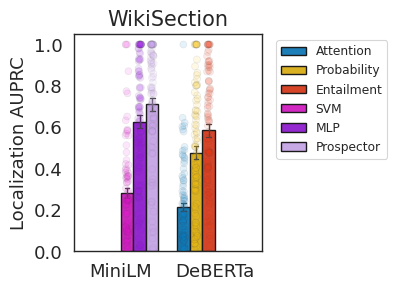

In [15]:
for met in test_metrics:
    subdf = combined_df[combined_df.metric == met].reset_index()
    plt.clf()
    # p=sns.color_palette("Set1")
    # colors at: https://xkcd.com/color/rgb/
    p=sns.xkcd_palette(["cerulean","goldenrod","vermillion","fuchsia","violet","lavender","mahogany","celadon"])
    if met == 'auprc':
        setup_figure(6,3) #(3,3)
        hue_order = ["Attention", "Probability", "Entailment", 'SVM', 'MLP', "Prospector"]
        ax = sns.barplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value', hue='method', hue_order=hue_order, orient='vertical', errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
        sns.stripplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value',  hue='method', hue_order=hue_order, orient='vertical', dodge=True, alpha=0.1, linewidth=0.5, ax=ax, legend=False)
        plt.title("WikiSection", fontsize=15)
        ax.set_ylabel('Localization AUPRC', fontsize=13)
        ax.set_xlabel('')
        ax.tick_params(labelsize=13)
        for p in ax.patches:
            y = p.get_height()
            print(y)
        plt.legend(loc="upper right", bbox_to_anchor=(1.7, 1)) # (loc='upper left') #  labels=['SVM', 'MLP', "Prospector"]
        
        # plt.legend(loc=(0.65,1.01))
    else:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 3), sharey=True, gridspec_kw={'wspace': 0})
        sns.barplot(data=subdf[subdf['regime'] == 'class-1'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, ax=ax2, errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="w")
        sns.stripplot(data=subdf[subdf['regime'] == 'class-1'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, alpha=0.1, linewidth=0.5, ax=ax2, legend=False)
        # ax1.yaxis.set_label_position('left')

        ax2.set_title('  '+'class-1', loc='left')
        ax2.set_ylabel('')
        ax2.set_yticklabels([])
        ax2.legend_.remove()
    
        sns.barplot(data=subdf[subdf['regime'] == 'all'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, ax=ax1, errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
        sns.stripplot(data=subdf[subdf['regime'] == 'all'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, alpha=0.1, linewidth=0.5, ax=ax1, legend=False)
        ax1.legend_.remove()
    
        # optionally use the same scale left and right
        xmax = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
        ax1.set_xlim(xmax=xmax)
        ax2.set_xlim(xmax=xmax)

        ax1.invert_xaxis()  # reverse the direction
        ax1.tick_params(axis='y', labelleft=True, left=True, labelright=False, right=False)
        ax1.set_ylabel('')
        ax1.set_title('all data'+'  ', loc='right')

        plt.legend(loc=(-1.01,1.02))
        fig.suptitle(met, fontsize=15)
    
    plt.tight_layout()
    # plt.savefig("/home/k2/K2/src/outputs/k2-test/k2-vs-baseline_" + met + ".png", dpi=2000, format='png')
    plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-vs-baseline_" + met + ".png", dpi=300, format='png')
    plt.show()

In [20]:
subdf[subdf.regime == 'all'].groupby(['encoder','method'])['value'].describe()[['mean','std']]

mean       std
encoder method                         
DeBERTa Attention    0.216577  0.190892
        Entailment   0.584484  0.283256
        Probability  0.476460  0.304743
MiniLM  MLP          0.626107  0.300554
        Prospector   0.710742  0.289105
        SVM          0.283974  0.233359

In [21]:
subdf[subdf.regime == 'all'].groupby(['encoder','method'])['value'].sem()

encoder  method     
DeBERTa  Attention      0.019902
         Entailment     0.029532
         Probability    0.031772
MiniLM   MLP            0.031335
         Prospector     0.030141
         SVM            0.024329
Name: value, dtype: float64